In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logictensornetworks as ltn
import pandas as pd

In [2]:
df = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/Cantilever/training.csv", on_bad_lines='skip', skiprows=1)
df = df.sample(frac=1) #shuffle
#df.sample(5)
#df.shape
df = df.head(int(len(df)*(70/100)))
df.shape

(25601, 11)

In [ ]:
df.drop_duplicates(keep= 'first', inplace=True) #eliminarea dublurilor liniilor
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
print('Null values in dataset are',len(df[df.isnull().any(1)]))
df.shape

In [3]:
x = df[['Severitate def', 'Severitate inc.', 'Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']]
y = df[['Pozitie']]

batch_size= 64
ds_train = tf.data.Dataset.from_tensor_slices((x[:21000],y[:21000])).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((x[21000:],y[21000:])).batch(batch_size)

Metal device set to: Apple M1


2022-04-28 15:04:36.669946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-28 15:04:36.670041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
#df['Freq 1    f1 [Hz]'] = df['Freq 1    f1 [Hz]'].astype(float, errors = 'raise')
df.dtypes

Pozitie            float64
Severitate def     float64
Severitate inc.    float64
Mod 1              float64
Mod 2              float64
Mod 3              float64
Mod 4              float64
Mod 5              float64
Mod 6              float64
Mod 7              float64
Mod 8              float64
dtype: object

In [5]:
f = ltn.Function.MLP(input_shapes=[10],output_shape=[1],hidden_layer_sizes=(20,20))

In [6]:
eq = ltn.Predicate.Lambda(
    #lambda args: tf.exp(-0.05*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))        
    lambda args: 1/(1+0.5*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))
)

In [7]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")

In [8]:
@tf.function
def axioms(x_data, y_data):
    x = ltn.Variable("x", x_data)
    y = ltn.Variable("y", y_data)
    return Forall(ltn.diag(x,y), eq([f(x),y])).tensor

In [9]:
for x, y in ds_test:
    print("Initial sat level %.5f"%axioms(x,y))
    break

Initial sat level 0.78308


2022-04-28 15:04:37.386551: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-28 15:04:37.386604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [10]:
metrics_dict = {
    'train_sat': tf.keras.metrics.Mean(name='train_sat'),
    'test_sat': tf.keras.metrics.Mean(name='test_sat'),
    'train_accuracy': tf.keras.metrics.RootMeanSquaredError(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.RootMeanSquaredError(name="test_accuracy")
}

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
@tf.function
def train_step(x, y):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(x, y)
        loss = 1.-sat
    gradients = tape.gradient(loss, f.trainable_variables)
    optimizer.apply_gradients(zip(gradients, f.trainable_variables))
    sat = axioms(x, y)
    metrics_dict['train_sat'](sat)
    # accuracy
    metrics_dict['train_accuracy'](y,f.model(x))
    
@tf.function
def test_step(x, y):
    # sat
    sat = axioms(x, y)
    metrics_dict['test_sat'](sat)
    # accuracy
    metrics_dict['test_accuracy'](y,f.model(x))

In [12]:
from collections import defaultdict

def train(
        epochs,
        metrics_dict, 
        ds_train, 
        ds_test, 
        train_step, 
        test_step,
        track_metrics=1,
        csv_path=None,
        scheduled_parameters=defaultdict(lambda : {})
    ):
    """
    Args:
        epochs: int, number of training epochs.
        metrics_dict: dict, {"metrics_label": tf.keras.metrics instance}.
        ds_train: iterable dataset, e.g. using tf.data.Dataset.
        ds_test: iterable dataset, e.g. using tf.data.Dataset.
        train_step: callable function. the arguments passed to the function
            are the itered elements of ds_train.
        test_step: callable function. the arguments passed to the function
            are the itered elements of ds_test.
        csv_path: (optional) path to create a csv file, to save the metrics.
        scheduled_parameters: (optional) a dictionary that returns kwargs for
            the train_step and test_step functions, for each epoch.
            Call using scheduled_parameters[epoch].
    """
    template = "Epoch {}"
    for metrics_label in metrics_dict.keys():
        template += ", %s: {:.4f}" % metrics_label
    if csv_path is not None:
        csv_file = open(csv_path,"w+")
        headers = ",".join(["Epoch"]+list(metrics_dict.keys()))
        csv_template = ",".join(["{}" for _ in range(len(metrics_dict)+1)])
        csv_file.write(headers+"\n")
    
    for epoch in range(epochs):
        for metrics in metrics_dict.values():
            metrics.reset_states()

        for batch_elements in ds_train:
            train_step(*batch_elements,**scheduled_parameters[epoch])
        for batch_elements in ds_test:
            test_step(*batch_elements,**scheduled_parameters[epoch])

        metrics_results = [metrics.result() for metrics in metrics_dict.values()]
        if epoch%track_metrics == 0:
            print(template.format(epoch,*metrics_results))
        if csv_path is not None:
            csv_file.write(csv_template.format(epoch,*metrics_results)+"\n")
            csv_file.flush()
    if csv_path is not None:
        csv_file.close()

In [13]:
EPOCHS = 200

modelul = train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="regression_results.csv",
    track_metrics=1
)

2022-04-28 15:04:37.563413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-28 15:04:40.373608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-28 15:04:40.528660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-28 15:04:40.782857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 0, train_sat: 0.8727, test_sat: 0.8835, train_accuracy: 0.3148, test_accuracy: 0.2748
Epoch 1, train_sat: 0.8884, test_sat: 0.8954, train_accuracy: 0.2621, test_accuracy: 0.2442
Epoch 2, train_sat: 0.9011, test_sat: 0.9042, train_accuracy: 0.2304, test_accuracy: 0.2233
Epoch 3, train_sat: 0.9049, test_sat: 0.9050, train_accuracy: 0.2218, test_accuracy: 0.2220
Epoch 4, train_sat: 0.9053, test_sat: 0.9052, train_accuracy: 0.2213, test_accuracy: 0.2215
Epoch 5, train_sat: 0.9054, test_sat: 0.9054, train_accuracy: 0.2210, test_accuracy: 0.2212
Epoch 6, train_sat: 0.9055, test_sat: 0.9055, train_accuracy: 0.2208, test_accuracy: 0.2210
Epoch 7, train_sat: 0.9056, test_sat: 0.9056, train_accuracy: 0.2207, test_accuracy: 0.2208
Epoch 8, train_sat: 0.9056, test_sat: 0.9056, train_accuracy: 0.2205, test_accuracy: 0.2206
Epoch 9, train_sat: 0.9057, test_sat: 0.9057, train_accuracy: 0.2203, test_accuracy: 0.2204
Epoch 10, train_sat: 0.9058, test_sat: 0.9058, train_accuracy: 0.2201, test_accu

In [18]:
import seaborn as sns
sns.set(font_scale=1.2)

/Users/eduard.hogea/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/eduard.hogea/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


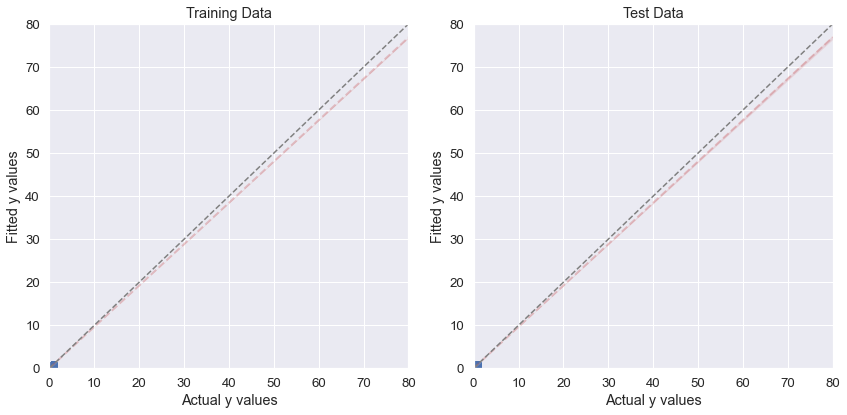

In [19]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
ax = axs[0]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_train:
    data['y_pred'].extend(f.model(x)[:,0].numpy())
    data['y_true'].extend(y[:,0].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_xlim(0,80)
ax.set_ylim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Training Data")

ax = axs[1]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_test:
    data['y_pred'].extend(f.model(x)[:,0].numpy())
    data['y_true'].extend(y[:,0].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_ylim(0,80)
ax.set_xlim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Test Data")
plt.tight_layout()
plt.savefig("LTN_regresie_1.pdf")

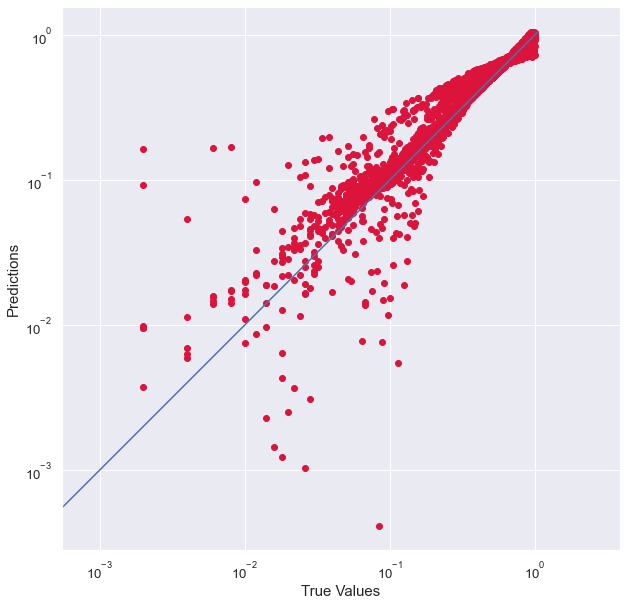

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(df['y_true'], df['y_pred'], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(df['y_pred']), max(df['y_true']))
p2 = min(min(df['y_pred']), min(df['y_true']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.savefig("LTN_regresie_2")
plt.show()

In [26]:

tabel4_lucrare = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/Cantilever/date_tabel4_v2.csv", on_bad_lines='skip')
tabel4_lucrare.head(10)

,Pozitie,Severitate def,Severitate inc.,Mod 1,Mod 2,Mod 3,Mod 4,Mod 5,Mod 6,Mod 7,Mod 8
0,0.100,0.0010,0.000000,0.002393,0.001227,0.000540,0.000099,0.000015,0.000075,0.000336,0.000652
1,0.150,0.0010,0.000000,0.001899,0.000254,0.000038,0.000552,0.001173,0.001254,0.000798,0.000219
2,0.400,0.0010,0.000000,0.000644,0.001020,0.000683,0.000299,0.001480,0.000037,0.001166,0.000771
3,0.550,0.0010,0.000000,0.000240,0.001535,0.000256,0.001080,0.000632,0.000640,0.001072,0.000240
4,0.613,0.0010,0.000000,0.000141,0.001343,0.000991,0.000146,0.001467,0.000171,0.000805,0.001136
5,0.133,0.0010,0.001673,0.002224,0.000466,0.000003,0.000336,0.001015,0.001417,0.001310,0.000770
6,0.280,0.0012,0.001673,0.004237,0.002804,0.004348,0.003654,0.002554,0.003922,0.004598,0.002963
7,0.410,0.0010,0.001673,0.002522,0.003063,0.002483,0.002346,0.003381,0.001844,0.003377,0.002300
8,0.570,0.0010,0.001673,0.000218,0.001670,0.000507,0.000837,0.001160,0.000208,0.001627,0.000020
9,0.962,0.0006,0.000433,0.000412,0.000412,0.000414,0.000419,0.000429,0.000446,0.000472,0.000507


In [27]:
X = tabel4_lucrare.drop(['Pozitie'], axis = 1)
y = tabel4_lucrare[['Pozitie']].values